In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pg48-feature-importance/pg48_feature_importance_sample_catboost.csv
/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


```
# 컬럼별로 다른 스케일링 방법 설정
column_transformer = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), ['A']),  # A 컬럼에 표준화 적용
        ('minmax', MinMaxScaler(), ['B']),      # B 컬럼에 최소-최대 정규화 적용
        ('robust', RobustScaler(), ['C'])       # C 컬럼에 로버스트 스케일링 적용
    ]
)

# 훈련 세트에 대해 변환기 학습 및 변환 적용
train_scaled = column_transformer.fit_transform(train_df)
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns)

# 테스트 세트에 대해 변환 적용 (fit을 다시 하지 않음)
test_scaled = column_transformer.transform(test_df)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns)
```

# Data Load

In [1]:
import polars as pl
import numpy as np
import pandas as pd

train = pl.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test = pl.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
sample_submission = pl.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
feature_importance = pl.read_csv("/kaggle/input/pg48-feature-importance/pg48_feature_importance_sample_catboost.csv")

In [2]:
!pip install ucimlrepo --quiet

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=848)
# https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset
  
# data (as Polars dataframes) 
X = pl.DataFrame(mushroom.data.features) 
y = pl.DataFrame(mushroom.data.targets)
y.columns = ['class']
others = pl.concat([y,X],how='horizontal')
train = train.drop('id')
train = pl.concat([train, others])

del mushroom, X, y, others

In [4]:
len(train) # total number of train data

3178014

# Test Modeling

## Rough data preprocessing with missing imputation

In [6]:
train = train.to_pandas()
# 수치형 컬럼의 결측치를 평균값으로 대체
numeric_cols = train.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    train[col] = train[col].fillna(train[col].mean())

# 카테고리형 컬럼의 결측치를 'known' 문자열로 대체
category_cols = train.select_dtypes(include=[object]).columns
for col in category_cols:
    train[col] = train[col].fillna('known')

## Catboost (Baseline model)

In [7]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

target_col = 'class'
random_state = 777

# 피쳐와 타겟 변수 분리
X = train.drop(target_col, axis=1)
y = train[target_col]

# 수치형과 카테고리형 컬럼 지정
cat_features = list(X.select_dtypes(include=[object]).columns)
num_features = [col for col in X.columns if col not in cat_features]

# 데이터를 학습용과 검증용으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=random_state, stratify=y)

# CatBoostClassifier 모델 초기화
model = CatBoostClassifier(
    iterations=1000,           # 부스팅 반복 횟수
    depth=6,                  # 트리 깊이
    learning_rate=0.05,        # 학습률
    cat_features=cat_features,  # 범주형 피쳐 목록
    task_type='GPU',          # GPU 사용 설정
    devices='0',              # 사용할 GPU 장치 (0은 첫 번째 GPU, 필요에 따라 조정)
    verbose=200,               # 학습 과정 출력 주기
    random_state = random_state
)

# 모델 학습
print("[START] fit CatBoost")
model.fit(X_train, y_train)
print("[FINISH] fit CatBoost")
print()

# 검증 데이터로 예측 수행
y_pred = model.predict(X_val)

# 모델 평가
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# 예측 결과 출력
print("Predictions:", y_pred)

[START] fit CatBoost
0:	learn: 0.2879000	total: 4.28s	remaining: 3h 33m 53s
100:	learn: 0.0394885	total: 43.6s	remaining: 20m 52s
200:	learn: 0.0367478	total: 1m 25s	remaining: 19m 51s
300:	learn: 0.0350298	total: 2m 11s	remaining: 19m 36s
400:	learn: 0.0336689	total: 2m 56s	remaining: 19m 6s
500:	learn: 0.0325678	total: 3m 44s	remaining: 18m 40s
600:	learn: 0.0315283	total: 4m 32s	remaining: 18m 8s
700:	learn: 0.0306302	total: 5m 20s	remaining: 17m 31s
800:	learn: 0.0297483	total: 6m 10s	remaining: 16m 57s
900:	learn: 0.0289630	total: 6m 59s	remaining: 16m 16s
1000:	learn: 0.0281868	total: 7m 49s	remaining: 15m 38s
1100:	learn: 0.0273814	total: 8m 39s	remaining: 14m 56s
1200:	learn: 0.0266577	total: 9m 28s	remaining: 14m 12s
1300:	learn: 0.0259711	total: 10m 19s	remaining: 13m 29s
1400:	learn: 0.0252791	total: 11m 9s	remaining: 12m 44s
1500:	learn: 0.0246425	total: 12m	remaining: 12m
1600:	learn: 0.0240298	total: 12m 52s	remaining: 11m 14s
1700:	learn: 0.0234057	total: 13m 44s	remaini

## Submission

In [13]:
test = test.drop('id')
test = test.to_pandas()
# 수치형 컬럼의 결측치를 평균값으로 대체
numeric_cols = test.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    test[col] = test[col].fillna(train[col].mean())

# 카테고리형 컬럼의 결측치를 'known' 문자열로 대체
category_cols = test.select_dtypes(include=[object]).columns
for col in category_cols:
    test[col] = test[col].fillna('known')

y_pred_test = model.predict(test)

sample_submission = sample_submission.to_pandas()
sample_submission['class'] = y_pred_test
sample_submission.to_csv('submission.csv', index=False)

# Feature Importance

In [ ]:
from catboost import Pool

# feature_importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_features))
feature_importances = model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)
feature_importance_df.to_csv('feature_importance_sample_catboost.csv', index=False)

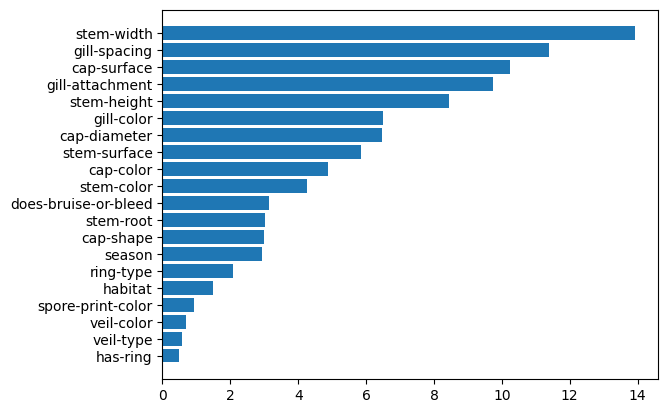

In [5]:
import matplotlib.pyplot as plt
feature_importance_plt = feature_importance.sort(by=['Importance'], descending=False)

plt.barh(feature_importance_plt['Feature'], feature_importance_plt['Importance'])
plt.show()

# Correlation with categorical columns

In [23]:
import pandas as pd
from scipy.stats import chi2_contingency
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 카테고리형 컬럼들을 모두 선택
def get_categorical_columns(df):
    return [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']

# 2. 카이제곱 검정의 p-값을 매트릭스로 계산
def calculate_chi_square_matrix(df, cat_columns, p_value_threshold=0.10):
    p_value_matrix = pd.DataFrame(np.nan * np.zeros((len(cat_columns), len(cat_columns))), 
                                  index=cat_columns, columns=cat_columns)

    # 컬럼 쌍에 대해 카이제곱 검정 수행
    print("[START] calcuate chi square matrix")
    for col1, col2 in itertools.combinations(cat_columns, 2):
        cross_tab = pd.crosstab(df[col1], df[col2])
        contingency_table = cross_tab.values

        try:
            chi2, p, dof, ex = chi2_contingency(contingency_table)
            if p <= p_value_threshold:
                p_value_matrix.loc[col1, col2] = p
                p_value_matrix.loc[col2, col1] = p  # 대칭 매트릭스이므로 반대쪽에도 같은 값 삽입
        except ValueError:
            print(f"Skipping pair {col1} vs {col2} due to non-numeric values.")
            continue
    print("[END] calcuate chi square matrix")
    return p_value_matrix

# 3. p-값 히트맵 시각화
def plot_p_value_heatmap(p_value_matrix):
    plt.figure(figsize=(12, 10))
    sns.heatmap(p_value_matrix, annot=True, fmt=".3f", cmap="coolwarm", mask=p_value_matrix.isnull(),
                vmin=0, vmax=1, cbar_kws={"label": "p-value"})
    plt.title("Chi-Square p-Value Matrix")
    plt.show()

[START] calcuate chi square matrix
[END] calcuate chi square matrix


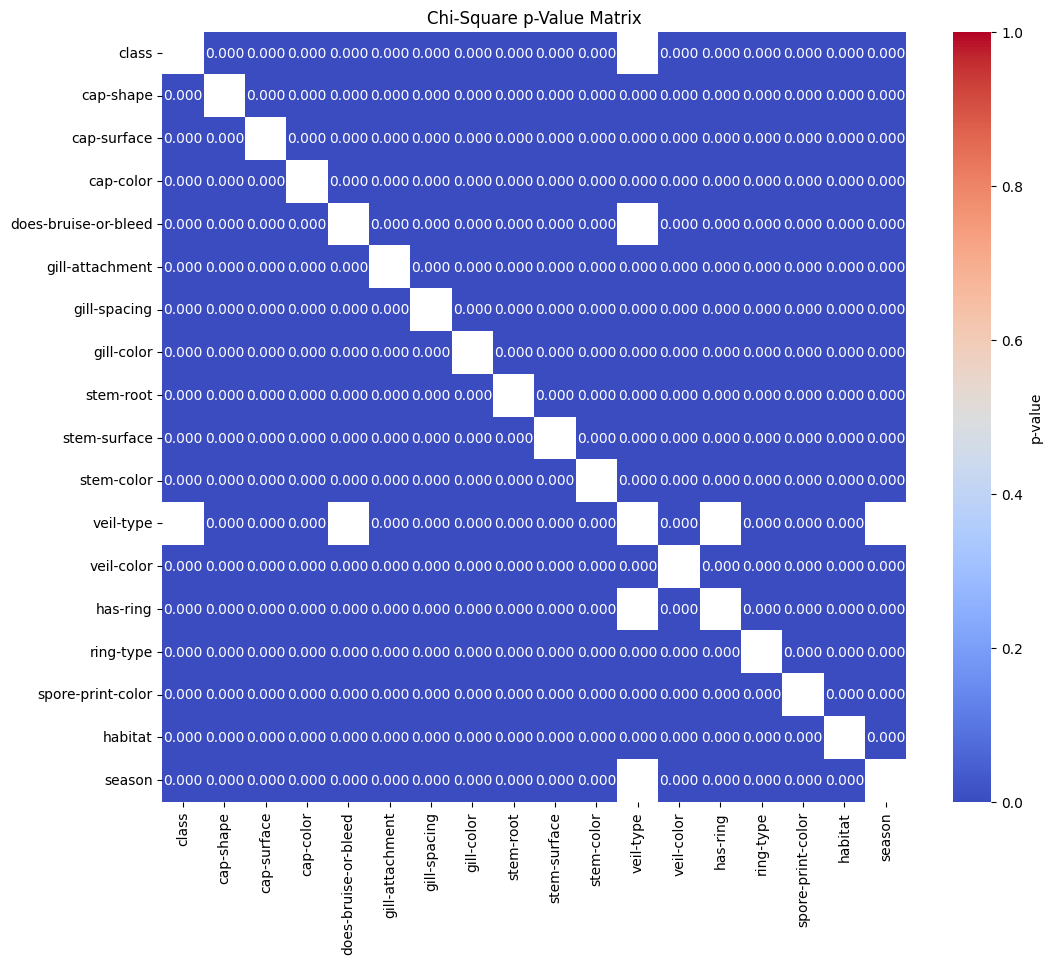

In [25]:
cat_columns = get_categorical_columns(train.to_pandas())
p_value_matrix = calculate_chi_square_matrix(train.to_pandas(), cat_columns, p_value_threshold=0.10)
plot_p_value_heatmap(p_value_matrix)

# Data Cleaning

## Remove duplicates

In [30]:
print("There are {} duplicates.".format(train.is_duplicated().sum()))

There are 266 duplicates.


In [31]:
train = train.unique()
print("There are {} duplicates.".format(train.is_duplicated().sum()))

There are 0 duplicates.


## Grouping rare categories
- : together into a new category called "the_others"
- Reference: https://www.kaggle.com/code/annastasy/ps4e8-data-cleaning-and-eda-of-mushrooms#-3.-Data-Cleaning-
- train dataset에서 적용한 grouping을 test dataset에도 적용하도록 수정

In [32]:
from tqdm.auto import tqdm

# Define a function to identify and replace infrequent categories
def replace_infrequent_categories(train, test, replace_value, threshold=100):
    train, test = train.to_pandas(), test.to_pandas()
    category_cols = list(train.select_dtypes(include=[object]).columns)
    category_cols.remove('class')
    for category_col in tqdm(category_cols):
        value_counts = train[category_col].value_counts()
        infrequent = value_counts[value_counts <= threshold].index
        train[category_col] = train[category_col].apply(lambda x: replace_value if x in infrequent else x)
        test[category_col] = test[category_col].apply(lambda x: replace_value if x in infrequent else x)
    return train, test

train_ric, test_ric = replace_infrequent_categories(train, test, replace_value='the_others', threshold=100)

# Print out number of unique columns after a replacement
print("After a replacement:")
for column in list(train_ric.select_dtypes(include=[object]).columns):
    num_unique = train_ric[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")
    
del train, test

  0%|          | 0/17 [00:00<?, ?it/s]

After a replacement:
'class' has 2 unique categories.
'cap-shape' has 8 unique categories.
'cap-surface' has 12 unique categories.
'cap-color' has 13 unique categories.
'does-bruise-or-bleed' has 3 unique categories.
'gill-attachment' has 8 unique categories.
'gill-spacing' has 4 unique categories.
'gill-color' has 13 unique categories.
'stem-root' has 6 unique categories.
'stem-surface' has 9 unique categories.
'stem-color' has 14 unique categories.
'veil-type' has 2 unique categories.
'veil-color' has 7 unique categories.
'has-ring' has 3 unique categories.
'ring-type' has 9 unique categories.
'spore-print-color' has 8 unique categories.
'habitat' has 9 unique categories.
'season' has 4 unique categories.


## Check the number of missing values in each column

In [33]:
# Null 개수 계산 후 퍼센트로 변환

train_null = (pl.DataFrame(train_ric).null_count() / len(train_ric)) * 100

# pandas 데이터프레임으로 변환
train_null = train_null.to_pandas()

# null 비율이 높은 순서로 컬럼 정렬
train_null_sorted = train_null.sort_values(by=train_null.index[0], axis=1, ascending=False)

In [34]:
pl.DataFrame(train_null_sorted)

veil-type,spore-print-color,stem-root,veil-color,stem-surface,gill-spacing,cap-surface,gill-attachment,ring-type,gill-color,habitat,cap-shape,stem-color,has-ring,cap-color,does-bruise-or-bleed,cap-diameter,class,stem-width,stem-height,season
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
94.882449,91.3908,88.378718,87.934961,63.532626,40.388619,21.559832,16.797142,4.133306,0.001794,0.001416,0.001259,0.001196,0.000755,0.000378,0.000252,0.000126,0.0,0.0,0.0,0.0


## Fillna in Numerical columns

In [35]:
categorical_columns = list(train_ric.select_dtypes(include=[object]).columns)
categorical_columns.remove('class')
numerical_columns = train_ric.select_dtypes(include=[np.number]).columns
print(train_ric[numerical_columns].skew())
print()
print(train_ric[numerical_columns].isnull().sum())

cap-diameter    3.970994
stem-height     1.937220
stem-width      1.274459
dtype: float64

cap-diameter    4
stem-height     0
stem-width      0
dtype: int64


In [38]:
import pandas as pd
from sklearn.impute import KNNImputer

train_impute = train_ric.copy()

# 결측치를 대체할 특정 컬럼 리스트
columns_to_impute = ['cap-diameter']

# KNNImputer 객체 생성
imputer = KNNImputer(n_neighbors=5)  # n_neighbors는 K 값 (K-최근접 이웃 수)

# 데이터프레임에서 대체할 컬럼만 선택
data_to_impute = train_impute[columns_to_impute]

# KNN을 사용하여 결측치 대체
imputed_data = imputer.fit_transform(data_to_impute)
# test 셋의 경우
# imputed_data = imputer.transform(data_to_impute) 

# 결과를 데이터프레임으로 변환
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute)

# 원래 데이터프레임에 대체된 값 통합
train_impute[columns_to_impute] = imputed_df

del train_ric, imputed_data, imputed_df

In [39]:
print(train_impute[numerical_columns].isnull().sum())

cap-diameter    0
stem-height     0
stem-width      0
dtype: int64


## Save a result of train dataset imputed and knn imputer

In [40]:
train_impute.to_csv('train_impute.csv', index=False)

In [41]:
import pickle

with open('knn_imputer.pkl', 'wb') as file:
    pickle.dump(imputer, file)
    
# 저장된 KNNImputer 객체를 파일에서 로드
# with open('/kaggle/input/train-dataset-imputed/knn_imputer.pkl', 'rb') as file:
#     imputer = pickle.load(file)

## Drop columns

- veil-type: has to be removed (low variable importance, a lot of missing values)
- has-ring: has to be removed (lowest variable importance)
- veil-color: has to be removed (low variable importance, a lot of missing values)
- spore-print-color: has to be removed (low variable importance, a lot of missing values)
- habitat: be put on hold for removal (low variable importance, but few missing values and reasonable meaning)
    - the meaning of habitat: the environment where mushrooms grow (grasses (g), leaves (l), ...)

In [43]:
train_drop = train_impute.copy()
train_drop = train_drop.drop(columns = ['veil-type', 'has-ring', 'veil-color', 'spore-print-color'])

del train_impute

In [44]:
train_drop.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,ring-type,habitat,season
0,p,3.33,f,w,u,f,a,c,u,6.20,6.01,None,s,u,f,l,a
1,p,3.80,f,t,n,f,x,c,p,5.50,3.42,None,i,g,f,d,a
2,p,6.57,f,None,n,f,d,c,y,6.08,11.03,b,None,n,f,l,w
3,e,7.85,x,t,y,t,x,c,y,8.55,15.09,None,None,w,f,d,a
4,p,9.53,x,i,n,f,a,None,n,11.14,15.31,s,None,n,f,d,a


## Fillna in Categorical columns

**Ways to fillna in categorical columns**
1. Replace the missing values with 'known'
2. KNN
    - If there are too many number of missing values, KNN is not available.
3. Imputation with Mode
4. Imputation with Group Mode

In [45]:
categorical_columns = list(train_drop.select_dtypes(include=[object]).columns)
categorical_columns.remove('class')

print(train_drop[categorical_columns].isnull().sum())

cap-shape                    40
cap-surface              685143
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          533791
gill-spacing            1283497
gill-color                   57
stem-root               2808559
stem-surface            2018983
stem-color                   38
ring-type                131351
habitat                      45
season                        0
dtype: int64


In [48]:
# Null 개수 계산 후 퍼센트로 변환

train_null = (pl.DataFrame(train_drop).null_count() / len(train_drop)) * 100

# pandas 데이터프레임으로 변환
train_null = train_null.to_pandas()

# null 비율이 높은 순서로 컬럼 정렬
train_null_sorted = train_null.sort_values(by=train_null.index[0], axis=1, ascending=False)

pl.DataFrame(train_null_sorted)

stem-root,stem-surface,gill-spacing,cap-surface,gill-attachment,ring-type,gill-color,habitat,cap-shape,stem-color,cap-color,does-bruise-or-bleed,class,stem-width,stem-height,cap-diameter,season
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
88.378718,63.532626,40.388619,21.559832,16.797142,4.133306,0.001794,0.001416,0.001259,0.001196,0.000378,0.000252,0.0,0.0,0.0,0.0,0.0


# Encoding

## Encoding Catorical Columns

1. Ordinal Encoding
    - Label encoding should be used to encode target values, i.e. y, and not the input X.
    - Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
2. Binary Encoding
3. Hashing